# Searching for rare cell-types: Part 2

In part 1 we explored how to use perisomatic features to enrich our search space for one examples of a unique cell of interest in the MICrONS dataset - the chandelier cell. In this tutorial. we will walk through a second, less well documented example of an inhibitory cell that targets Layer 5-NP cells. As mentioned in part 1 - this example is highlight in Fig. 6 of the accompanying manuscript but can be extended to a wide variety of inihibitory cells.  

In [58]:
import pandas as pd
import numpy as np 
import pcg_skel
import matplotlib.pyplot as plt
import seaborn as sns
from meshparty import meshwork
import caveclient
import numpy as np
from meshparty import trimesh_io
from nglui.statebuilder import *
import skeleton_plot
%matplotlib inline

To start out, let's take a look at all the predicted inhibitory neurons in the dataset in the 2D UMAP embedding space. Note that this embedding only shows inhibitory neurons as it includes 120 Post-Synaptic Shape (PSS) features.

The following plot shows all the predicted inhibitory neurons in gray with the manually labeled cortical column cells in color (Fig. 4).

In [59]:
df = pd.read_pickle('../data/inhibitory_perisomatic_feats_v661.pkl')


In [60]:
#Custom color palette
color_dict = {'23P':'#8268DC',
              '4P':'#647FDC',
              '5P-IT':'#77BCDE',
              '5P-ET':'#87DD90',
              '5P-NP':'#85DEC9',
              '6P-CT':'#96DD70',
              '6P-IT':'#DCC86E',
              'BC':'#D68C66',
              'BPC':'#D3697C',
              'MC':'#D36BBA',
              'NGC':'#BC6BDB',
              'astrocyte':'#009245',
              'pericyte':'#754C24',
              'microglia':'#006837',
              'oligo':'#8CC63F',
              'OPC':'#998675',
              'error':'#899499'
    
}

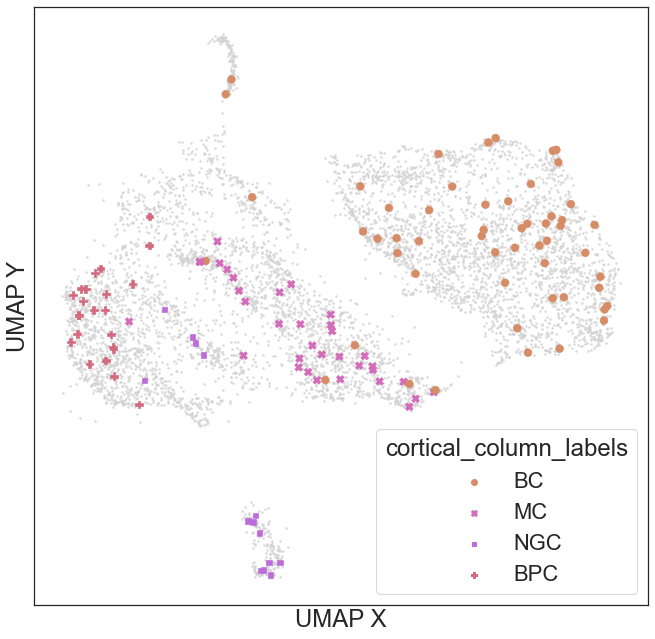

In [61]:
f, ax =plt.subplots(figsize=(11,11), facecolor='white')

sns.scatterplot( x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', color='lightgray',
                ax =ax, s=5, alpha=0.9, edgecolor=None, data=df, legend = True)

sns.scatterplot( x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', 
                ax =ax, s=60, alpha=1, hue='cortical_column_labels',style='cortical_column_labels',
                palette=color_dict, legend = True,
                c=(.2,.2,.2),edgecolor=None, data=df)

ax.set_xlabel('UMAP X', fontsize=24)
ax.set_ylabel('UMAP Y', fontsize=24)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## 5P-NP Targetting Cell

The type of inhibitory is not well documented in the literature, however it has a unique targetting profile. Specifically, it targets the Layer 5 pyramidal near-projecting (NP) cells. These pyramidal cells are quite sparse themselves and have notably low synapse density.

Let's look at what one of these cell's look like in the MICrONS dataset

In [62]:
#Setting up our client to access the data
client = caveclient.CAVEclient('minnie65_public')

#Our nucleus table with all cells with a soma within the dataset
nuc_df = client.materialize.query_table('nucleus_detection_v0', split_positions=True, 
                                       desired_resolution=(1000,1000,1000))

In [64]:
np_targetting_nuc_id = 434607
np_targetting_cell = nuc_df.query('id == @np_targetting_nuc_id').pt_root_id.values[0]

#This allows us to download meshes 
mm = trimesh_io.MeshMeta(cv_path=client.info.segmentation_source(), disk_cache_path='../minnie_meshes')

#Download our mesh of interest, NOTE the first time you run this may take a few minutes
mesh = mm.mesh(seg_id=np_targetting_cell)

Let's skeletonize our cell - note the following cell may take a minute

In [65]:
#Defining our root point (the soma point in this case)
# chand_nuc_id = 485719
# root_id = nuc_df.query(f'id=={chand_nuc_id}').pt_root_id.values[0]
root_point = nuc_df.query(f'id=={np_targetting_nuc_id}')[['pt_position_x', 'pt_position_y', 'pt_position_z']].iloc[0,:].values

#Skeletonizing our cell of interest
mw=pcg_skel.coord_space_meshwork(np_targetting_cell, client=client, root_point=root_point, 
                                root_point_resolution=[nuc_df.attrs['dataframe_resolution']],
                                collapse_soma=True, synapses='all', 
                                synapse_table=client.materialize.synapse_table)

100%|██████████| 7050/7050 [00:00<00:00, 16675.14it/s]


In [66]:
#Adding volumetric properties
pcg_skel.features.add_volumetric_properties(mw, client)
pcg_skel.features.add_segment_properties(mw)

volume_df = mw.anno.segment_properties.df
# add column indicating skel index 
volume_df['skel_index'] = mw.anno.segment_properties.mesh_index.to_skel_index_padded
sk_volume_df = volume_df.drop_duplicates('skel_index').sort_values('skel_index').reset_index()
# pull out map for skel index -> radius
radius_labels = np.array(sk_volume_df['r_eff'])
mw.skeleton.vertex_properties['radius'] = radius_labels

#Adding a mask for the axon
axon_inds, Q = meshwork.algorithms.split_axon_by_annotation(mw, pre_anno='pre_syn', post_anno='post_syn')
mw.anno.add_annotations('is_axon', axon_inds, mask=True)

mw.mesh.vertices=mw.mesh.vertices/1000
mw.skeleton.vertices=mw.skeleton.vertices/1000

In [67]:
#Adding a filter to our presynapses to ensure the synapses are on the axon
presyn_df = mw.anno.pre_syn.df
axon_syn = []
for i in presyn_df.pre_pt_mesh_ind:
    if i in axon_inds:
        axon_syn.append(True)
    else:
        axon_syn.append(False)

presyn_df['is_axon'] = axon_syn
axon_syn_df = presyn_df.query('is_axon==True')
axon_syn_ids = axon_syn_df.id.tolist() #list of synapse ids on the axons

Here is the morphology of our inhibitory cell of interest

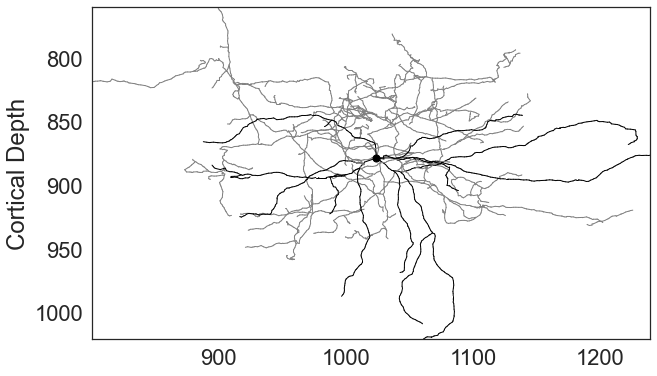

In [68]:
#list of indices to color differently
axon_skel_inds = mw.anno.is_axon.skel_index
skel_clist = []
for i in range(mw.skeleton.vertices.shape[0]):
    if i in axon_skel_inds.tolist():
        skel_clist.append(0)
    else:
        skel_clist.append(1)
        
len(skel_clist)


skel_cmap = {
    0:'gray', #axon 
    1:'black' #dendrite
}

f, ax = plt.subplots(figsize=(10, 10))

skeleton_plot.plot_tools.plot_mw_skel(mw, 
                                      plot_soma=True ,
                                      #radii=mw.skeleton.vertex_properties['radius']/200,
                                      invert_y=True,
                                      soma_size=50,
                                      skel_colors=skel_clist,
                                     skel_color_map=skel_cmap)

ax.set_ylabel('Cortical Depth')

plt.show()

To add synapses we'll query the synapse table and merge in the perisomatic predictions for all the target cells.

In [69]:
#Synapse table query for all synapses made by our cell of interest
syn_out_df = client.materialize.synapse_query(pre_ids=np_targetting_cell,
                                             split_positions=True,
                                             desired_resolution=(1000,1000,1000))

#The cell-type table using the cell-class and subclass scheme applied in the manuscript
mm_df = client.materialize.query_table('aibs_metamodel_celltypes_v661', 
                                       split_positions=True, desired_resolution=(1000,1000,1000))

syn_out_df=syn_out_df.merge(mm_df[['id_ref', 'cell_type', 'pt_root_id']], 
                         left_on='post_pt_root_id', 
                         right_on='pt_root_id', how='left')



With the added synapses, you can see the target preference for Layer 5P-NP pyramidal cells shown in light blue.

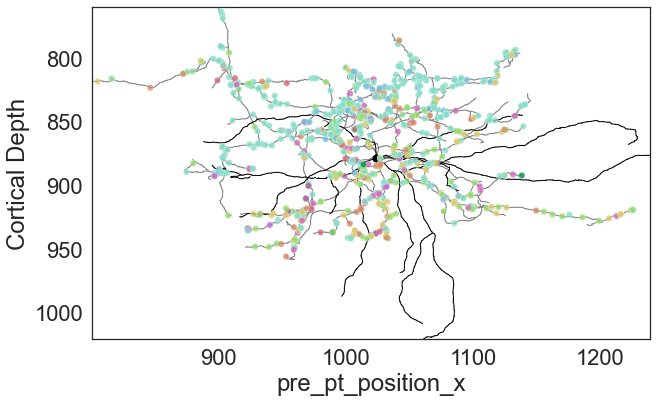

In [70]:

f, ax = plt.subplots(figsize=(10, 10))

#Plotting output synapses colored by predicted target subclass
sns.scatterplot(data = syn_out_df.query('id in @axon_syn_ids'),
                 x='pre_pt_position_x', y='pre_pt_position_y', hue = 'cell_type',
                 s=40, alpha=0.8, linewidth=0.3,
                 ax=ax, palette=color_dict, legend=False, zorder=25)  

skeleton_plot.plot_tools.plot_mw_skel(mw, 
                                      plot_soma=True ,
                                      invert_y=True,
                                      soma_size=50,
                                      skel_colors=skel_clist,
                                     skel_color_map=skel_cmap)

ax.set_ylabel('Cortical Depth')
plt.show()

### Selecting nearest neighbors

Now that we have identified our cell of interest as a cell that target Layer 5P-NP cells, we want to increase our sample set and identify more cells in the dataset that may have similar targetting preferences. To do this we will use a KDTree graph based on the perisomatic features and select the top 20 nearest neighbors.

In [71]:
from sklearn.neighbors import KDTree

In [72]:
#Load the zscored perisomatic features for all predicted inhibitory cells
inhibitory_cells = np.load('../data/inhibitory_normalized_perisomatic_features.npy')

#KDTree on high dimensional feature space
kdt = KDTree(inhibitory_cells, leaf_size=30, metric='euclidean')

#Id of our chandelier cell of interest
idx = df.query('nucleus_id == @np_targetting_nuc_id').index[0]
X = inhibitory_cells[idx,:].reshape(1,133) #corresponding feature vector for that cell

#Query for the top 20 nearest neighbors 
similar_idxs = kdt.query(X, k=20, return_distance=False)
similar_neurons = df.soma_id.to_numpy()[similar_idxs].tolist()[0]
similar_neuron_nuc_ids = df.nucleus_id.to_numpy()[similar_idxs].tolist()[0]

If we plot these nearest neighbors in the 2D UMAP embedding space we can see where in this feature space these cells are coming from. Note that the nearest neighbors were selected from the high dimensional feature space not the 2D embedding.

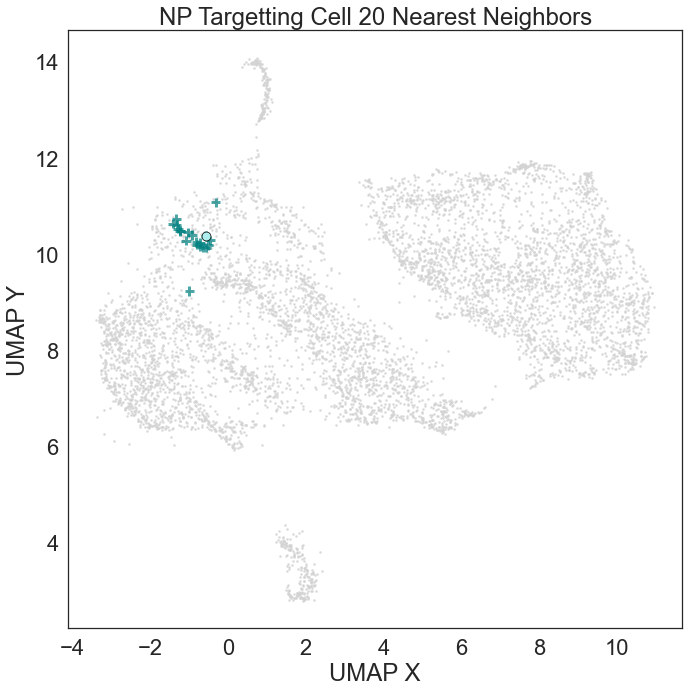

In [73]:
f, ax =plt.subplots(figsize=(11,11), facecolor='white')

sns.scatterplot( x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', color='lightgray',
                ax =ax, s=5, alpha=0.9, edgecolor=None, data=df, legend = True)


sns.scatterplot(x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', 
                ax =ax, alpha=.7, c = ['teal']*20,marker='+',linewidth=3,
                s=90, data=df.query('soma_id in @similar_neurons'))

sns.scatterplot(x='inhib_umap_embedding_x', y='inhib_umap_embedding_y', 
                ax =ax, alpha=1, c = ['paleturquoise'],edgecolor='black',
                s=80, data=df.query('nucleus_id == @np_targetting_nuc_id'))

ax.set_xlabel('UMAP X')
ax.set_ylabel('UMAP Y')
ax.set_title('NP Targetting Cell 20 Nearest Neighbors')

plt.show()

## Are these cells in fact 5P-NP targetting cells?

In [74]:
import math
from cell_search import get_syn_out_df

In [75]:
nuc_df = client.materialize.query_table('nucleus_detection_v0',  
                                       desired_resolution=(1000,1000,1000))
mm_df = client.materialize.query_table('aibs_metamodel_celltypes_v661', desired_resolution=(1000,1000,1000))

In [76]:
#Querying for the downstream synapses with cell-type predictions of the NP-targetting cell
syn_out = get_syn_out_df(np_targetting_cell)


Text(0.5, 1.0, 'Downstream Connectivity Preferences for NP Targetting Cell')

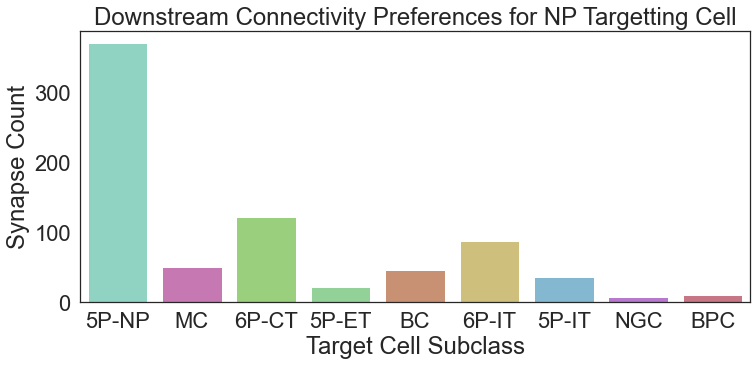

In [77]:
sns.set(style='white', font_scale =2)
f, ax = plt.subplots(figsize=(12,5))

nonneurons = ['microglia','OPC','astrocyte', 'oligo']
sns.countplot(data = syn_out.query('cell_type not in @nonneurons'),
            x='cell_type',alpha=1,
            palette=color_dict)

ax.set_ylabel('Synapse Count')
ax.set_xlabel('Target Cell Subclass')
ax.set_title('Downstream Connectivity Preferences for NP Targetting Cell')

### How do the similar neurons compare? 

To ensure that each neuron had a cleaned axon with at least 100 synapses we proofread and extended the nearest neurons, below we have provided the cleaned ids those neurons.

In [78]:
proofread_similar_neurons = [864691135274647269,864691135988273155,864691135213920384,
                             864691135618930063,864691136005920458,864691135463950910,
                             864691134948659708,864691136578788372,864691135741475179,
                             864691135163546157,864691135469525842,864691136991180181,
                             864691135654601154,864691135279479457,864691135877078867,
                             864691135685382071,864691135781958992,864691135293110198,
                             864691135293110710,864691135502759234,864691135594669611,
                             864691135772837451]

Now let's look at them all, note that the first row in this histogram is our 5P-NP targetting cell of interest.

In [79]:
#Querying the post synaptic targets for each neuron
#NOTE this takes about a minute to run 
neighbor_df = pd.DataFrame()
for ix,root_id in enumerate(proofread_similar_neurons):
    syn_out = get_syn_out_df(root_id) 
    syn_out['order_ix'] = [ix]*syn_out.shape[0]
    syn_out = syn_out.query('cell_type not in @nonneurons')
    neighbor_df = pd.concat([neighbor_df, syn_out])

In [80]:
#Binning the data by target cell_type
binned_df = neighbor_df.groupby(['pre_pt_root_id','cell_type']).size().unstack(fill_value=0)
#Normalizing the connectivity to get proportion output
binned_df = binned_df.div(binned_df.sum(axis=1), axis=0)
binned_df = binned_df.merge(neighbor_df[['pre_pt_root_id','order_ix']], how='left',
                           on='pre_pt_root_id')
binned_df = binned_df.sort_values('order_ix')
binned_df = binned_df.drop_duplicates()
binned_df = binned_df.reset_index()

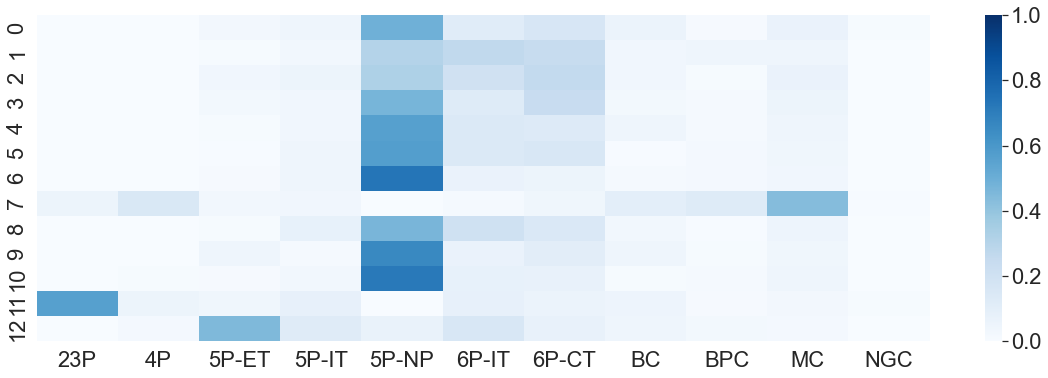

In [81]:
fig = plt.figure(figsize=(20,6))
labels = ['23P','4P','5P-ET','5P-IT','5P-NP','6P-IT','6P-CT','BC','BPC','MC','NGC']
sns.heatmap(binned_df[labels],cmap='Blues',vmin=0,vmax=1.0)
plt.show()

### How does this compare to a random sampling of inhibitory neurons? 

In [82]:
# To recreate the figures from the manuscript, the following random IDs were proofread with the same criteria as above
rand_ids = [864691135293116598,864691135911002793,864691135919637424,864691135387761025,
            864691135492620895,864691136228235089,864691135495538320,864691135940893606,
            864691136274097854,864691136391618431,864691136040542718,864691135940896678,
            864691136124889894,864691135489467194,864691135808625181,864691135919636912,
            864691135756014802,864691135447701332,864691134918590730,864691135874736782]

In [83]:
rand_df = pd.DataFrame()
for ix,root_id in enumerate(rand_ids):
    syn_out = get_syn_out_df(root_id)
    syn_out['order_ix'] = [ix]*syn_out.shape[0]
    syn_out = syn_out.query('cell_type not in @nonneurons')
    syn_out = syn_out.query('post_pt_root_id != @root_id')
    rand_df = pd.concat([rand_df, syn_out])

In [84]:
rand_binned_df = rand_df.groupby(['pre_pt_root_id','cell_type']).size().unstack(fill_value=0)
#Normalizing the connectivity to get proportion output
rand_binned_df = rand_binned_df.div(rand_binned_df.sum(axis=1), axis=0)
rand_binned_df = rand_binned_df.merge(rand_df[['pre_pt_root_id','order_ix']], how='left',
                           on='pre_pt_root_id')
rand_binned_df = rand_binned_df.sort_values('order_ix')
rand_binned_df = rand_binned_df.drop_duplicates()
rand_binned_df = rand_binned_df.reset_index()

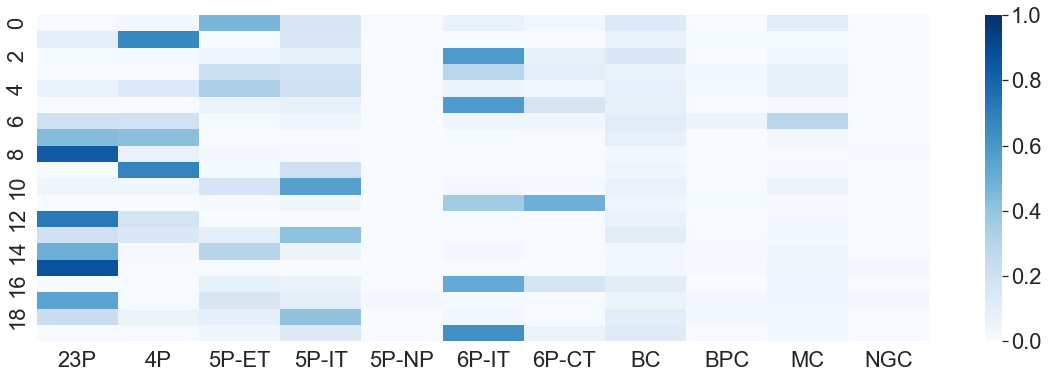

In [85]:
fig = plt.figure(figsize=(20,6))
sns.heatmap(rand_binned_df[labels],cmap='Blues',vmin=0,vmax=1.0)
plt.show()